# PixelRNN

In this notebook we imlement the RowLSTM architecture from the [PixelRNN paper](https://arxiv.org/abs/1601.06759). We use MNIST as our dataset of choice.


This notebook is partially inspired by the following [notebook](https://github.com/heechan95/PixelRNN-pytorch/blob/master/PixelRNN%20pytorch.ipynb).

In [2]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T

In [3]:
# PARAMETERS
NUM_EPOCHS = 50
BATCH_SIZE = 128
HIDDEN_DIM = 16
LR = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Masked Convolutions

The ```MaskedConvolution``` module automatically generates a convolution based on ```kernel_size``` and ```mask_type``` that is multiplied by a mask that contains either zeros or ones.

In [6]:
class MaskedConvolution(nn.Module):
    def __init__(self,
                in_channels,
                out_channels,
                kernel_size=(3,3),
                mask_type='B'):
        super().__init__()
        
        # determine the mask
        assert mask_type in ['A', 'B']
        mask = torch.zeros(kernel_size)
        mask[: kernel_size[0] // 2, :] = 1
        if mask_type == 'A':
            mask[kernel_size[0] // 2, : kernel_size[1] // 2] = 1
        elif mask_type == 'B':
            mask[kernel_size[0] // 2, : kernel_size[1] // 2 + 1] = 1
        # register_buffer makes sure that the mask is pushed to the device
        self.register_buffer('mask', mask)
        
        # add conv2d layer
        padding = tuple([(size-1)//2 for size in kernel_size])
        self.conv = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              padding=padding)
        
    def forward(self, x):
        with torch.inference_mode():
            self.conv.weight *= self.mask 
        return self.conv(x)

Assuming a 3x3 convolution and a mask of type 'A', we get the following mask.

In [9]:
masked_convolution = MaskedConvolution(in_channels=1, out_channels=1, kernel_size=(3, 3), mask_type='A')
print(masked_convolution.mask)

tensor([[1., 1., 1.],
        [1., 0., 0.],
        [0., 0., 0.]])


The mask of type 'B' is less conservative.

In [14]:
masked_convolution = MaskedConvolution(in_channels=1, out_channels=1, kernel_size=(3, 3), mask_type='B')
print(masked_convolution.mask)

tensor([[1., 1., 1.],
        [1., 1., 0.],
        [0., 0., 0.]])


In [15]:
# cleanup
del masked_convolution

## RowLSMT

The ```RowLSTMCell``` module processes one row at a time. The input to state convolution ```i_s``` is preprocessed for the whole image in a separate step and the row of the result is processed by the ```RowLSTM``` module in the loop one row at a time. We preprocess ```i_s``` in a separate step in order to improve the parallelization potential. ```i_s``` is based on the convolution and can thus be calculated very fast. The RowLSTM is calculated one row at a time and is therefore slower.

In [17]:
class RowLSTMCell(nn.Module):
    
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.conv_s_s = nn.Conv1d(in_channels=hidden_dim, 
                                out_channels=4 * hidden_dim,
                                kernel_size=3,
                                padding=1)

    def forward(self, i_s, h_prev, c_prev):
        s_s = self.conv_s_s(h_prev)
        
        # we split the tensor into 4 tensors, one for each part of the LSTM
        o, f, i, g = torch.split(i_s + s_s, self.hidden_dim, 1)
        
        # below is the typical LSTM calculation
        o = torch.sigmoid(o)
        f = torch.sigmoid(f)
        i = torch.sigmoid(i)
        g = torch.tanh(g)
        
        c = f * c_prev + i * g
        h = o * torch.tanh(c)
        return h, c

In [23]:
cell = RowLSTMCell(HIDDEN_DIM)
i_s = torch.randn(1, HIDDEN_DIM*4, 28)
h_prev = torch.randn(1, HIDDEN_DIM, 28)
c_prev = torch.randn(1, HIDDEN_DIM, 28)
h_prev, c_prev = cell(i_s, h_prev, c_prev)

del cell, i_s, h_prev, c_prev

The ```RowLSTM``` module is a recurrent layer with skip connections. We calculate input to state values using a ```MaskedConvolution``` module and the result is given to the ```RowLSTM``` one row at a time.

In [25]:
class RowLSTM(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.cell = RowLSTMCell(hidden_dim)
        self.i_s = MaskedConvolution(in_channels=hidden_dim*2,
                                    out_channels=hidden_dim*4,
                                    kernel_size=(1, 3))
        self.conv = nn.Conv2d(in_channels=hidden_dim,
                              out_channels=hidden_dim*2,
                              kernel_size=1)
        self.h_prev = torch.zeros(1, HIDDEN_DIM, 28, device=DEVICE)
        self.c_prev = torch.zeros(1, HIDDEN_DIM, 28, device=DEVICE)

    def forward(self, x):
        i_s = self.i_s(x)
        num_rows = 28
        rows = []
        
        h_prev = self.h_prev
        c_prev = self.c_prev
        
        for row_idx in range(num_rows):
            # batch_size, channels, height, width
            is_row = i_s[:, :, row_idx, :]            
            h_prev, c_prev = self.cell(is_row, h_prev, c_prev)
            rows.append(h_prev.unsqueeze(dim=2))
        out = torch.cat(rows, dim=2)
        out = self.conv(out)
        # skip connection
        out += x
        return out

In [32]:
# test row lstm
image = torch.randn(1, 16*2, 28, 28, device=DEVICE)
h_prev = torch.randn(1, 16, 28, device=DEVICE)
c_prev = torch.randn(1, 16, 28, device=DEVICE)
row_lstm = RowLSTM(16).to(DEVICE)
print(row_lstm(image).shape)

#clean up
del image, h_prev, c_prev, row_lstm

torch.Size([1, 32, 28, 28])


The final module is the complete ```PixelRNN``` model. We start with a 7x7 convolution of type 'A' and stack 7 ```RowLSTM``` modules. The output is of shape ```(Batch Size, 256, 1, 28, 28)```. Each of the 28x28 cells is input into a softmax layer (we use CrossEntropyLoss), wich allows us to sample integer pixel values between 0 and 255 at a later step.

In [28]:
class PixelRNN(nn.Module):
    
    def __init__(self, hidden_dim):
        super().__init__()
        self.layers = nn.Sequential(
                MaskedConvolution(in_channels=1, 
                                  out_channels=hidden_dim*2,
                                  kernel_size=(7, 7),
                                  mask_type='A'),
                nn.ReLU(),
                RowLSTM(hidden_dim),
                RowLSTM(hidden_dim),
                RowLSTM(hidden_dim),
                RowLSTM(hidden_dim),
                RowLSTM(hidden_dim),
                RowLSTM(hidden_dim),
                RowLSTM(hidden_dim),
                nn.ReLU(),
                nn.Conv2d(hidden_dim*2, hidden_dim*2, kernel_size=1),
                nn.ReLU(),
                nn.Conv2d(hidden_dim*2, 256, kernel_size=1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.view(-1, 256, 1, 28, 28)
        return x

In [31]:
# test PixelRNN
test_images = torch.randn(BATCH_SIZE, 1, 28, 28, device=DEVICE)
model = PixelRNN(16).to(DEVICE)
print(model(test_images).shape)

# cleanup
del test_images, model

torch.Size([128, 256, 1, 28, 28])


For the dataset we use only the `PILToTensor` transform, which transforms an image into a PyTorch tensor. We don't use `ToTensor`, because we that transformation would scale the image pixel values between 0 and 1 and we need to keep values between 0 and 255 in order to use those in the `CrossEntropyLoss`. The normalization is done separately in the training loop at a later point.

In [33]:
train_dataset = torchvision.datasets.MNIST(root='../datasets/', 
                                           train=True, 
                                           transform=T.PILToTensor(), 
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../datasets/', 
                                           train=False, 
                                           transform=T.PILToTensor(), 
                                           download=False)

In [34]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=2)

In [13]:
model = PixelRNN(HIDDEN_DIM).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True)

In [14]:
def train():
    for epoch in range(1, NUM_EPOCHS+1):
        train_losses = []
        test_losses = []
        for features, _ in tqdm(train_dataloader, leave=False):
            features = features.to(DEVICE)
            logits = model(features.float() / 255)
            loss = criterion(logits, features.long())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.cpu().item())
        
        # inference
        with torch.inference_mode():
            for features, _ in test_dataloader:
                features = features.to(DEVICE)
                logits = model(features.float() / 255)
                loss = criterion(logits, features.long())
                test_losses.append(loss.cpu().item())

        ce_train = sum(train_losses)/len(train_losses)
        ce_test = sum(test_losses)/len(test_losses)
        print(f'Epoch: {epoch}/{NUM_EPOCHS}, Cross Entropy Train: {ce_train:.4f}, Cross Entropy Test: {ce_test:.4f}')
        scheduler.step(ce_test)

The training of the `RowLSTM` architecture takes roughly 10 min per epoch on google colab. 

In [15]:
train()

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 1/50, Cross Entropy Train: 1.2262, Cross Entropy Test: 0.8382


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 2/50, Cross Entropy Train: 0.8309, Cross Entropy Test: 0.8181


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 3/50, Cross Entropy Train: 0.8170, Cross Entropy Test: 0.8094


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 4/50, Cross Entropy Train: 0.8100, Cross Entropy Test: 0.8035


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 5/50, Cross Entropy Train: 0.8048, Cross Entropy Test: 0.7996


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 6/50, Cross Entropy Train: 0.8003, Cross Entropy Test: 0.7945


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 7/50, Cross Entropy Train: 0.7960, Cross Entropy Test: 0.7906


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 8/50, Cross Entropy Train: 0.7922, Cross Entropy Test: 0.7866


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 9/50, Cross Entropy Train: 0.7885, Cross Entropy Test: 0.7828


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 10/50, Cross Entropy Train: 0.7851, Cross Entropy Test: 0.7814


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 11/50, Cross Entropy Train: 0.7818, Cross Entropy Test: 0.7760


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 12/50, Cross Entropy Train: 0.7776, Cross Entropy Test: 0.7717


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 13/50, Cross Entropy Train: 0.7741, Cross Entropy Test: 0.7701


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 14/50, Cross Entropy Train: 0.7707, Cross Entropy Test: 0.7733


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 15/50, Cross Entropy Train: 0.7674, Cross Entropy Test: 0.7596


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 16/50, Cross Entropy Train: 0.7649, Cross Entropy Test: 0.7597


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 17/50, Cross Entropy Train: 0.7626, Cross Entropy Test: 0.7539


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 18/50, Cross Entropy Train: 0.7609, Cross Entropy Test: 0.7520


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 19/50, Cross Entropy Train: 0.7580, Cross Entropy Test: 0.7534


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 20/50, Cross Entropy Train: 0.7572, Cross Entropy Test: 0.7524


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 21/50, Cross Entropy Train: 0.7561, Cross Entropy Test: 0.7496


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 22/50, Cross Entropy Train: 0.7539, Cross Entropy Test: 0.7469


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 23/50, Cross Entropy Train: 0.7517, Cross Entropy Test: 0.7489


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 24/50, Cross Entropy Train: 0.7503, Cross Entropy Test: 0.7439


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 25/50, Cross Entropy Train: 0.7507, Cross Entropy Test: 0.7439


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 26/50, Cross Entropy Train: 0.7485, Cross Entropy Test: 0.7431


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 27/50, Cross Entropy Train: 0.7491, Cross Entropy Test: 0.7406


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 28/50, Cross Entropy Train: 0.7478, Cross Entropy Test: 0.7382


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 29/50, Cross Entropy Train: 0.7449, Cross Entropy Test: 0.7430


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 30/50, Cross Entropy Train: 0.7430, Cross Entropy Test: 0.7373


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 31/50, Cross Entropy Train: 0.7420, Cross Entropy Test: 0.7416


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 32/50, Cross Entropy Train: 0.7408, Cross Entropy Test: 0.7334


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 33/50, Cross Entropy Train: 0.7395, Cross Entropy Test: 0.7320


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 34/50, Cross Entropy Train: 0.7385, Cross Entropy Test: 0.7330


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 35/50, Cross Entropy Train: 0.7384, Cross Entropy Test: 0.7545


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 36/50, Cross Entropy Train: 0.7361, Cross Entropy Test: 0.7280


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 37/50, Cross Entropy Train: 0.7356, Cross Entropy Test: 0.7364


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 38/50, Cross Entropy Train: 0.7416, Cross Entropy Test: 0.7297


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 39/50, Cross Entropy Train: 0.7342, Cross Entropy Test: 0.7259


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 40/50, Cross Entropy Train: 0.7326, Cross Entropy Test: 0.7266


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 41/50, Cross Entropy Train: 0.7326, Cross Entropy Test: 0.7286


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 42/50, Cross Entropy Train: 0.7305, Cross Entropy Test: 0.7256


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 43/50, Cross Entropy Train: 0.7298, Cross Entropy Test: 0.7206


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 44/50, Cross Entropy Train: 0.7286, Cross Entropy Test: 0.7284


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 45/50, Cross Entropy Train: 0.7279, Cross Entropy Test: 0.7190


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 46/50, Cross Entropy Train: 0.7278, Cross Entropy Test: 0.7282


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 47/50, Cross Entropy Train: 0.7265, Cross Entropy Test: 0.7265


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 48/50, Cross Entropy Train: 0.7252, Cross Entropy Test: 0.7138


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 49/50, Cross Entropy Train: 0.7259, Cross Entropy Test: 0.7281


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 50/50, Cross Entropy Train: 0.7247, Cross Entropy Test: 0.7286


In order to test the quality of this autoregressive generative model it makes sense to sample a couple of images. The model returns 255 logits that we use in a softmax layer and put as probability values into a `multinomial` distribution.

In [16]:
@torch.inference_mode()
def sample(model, num_images):
    width = 28
    height = 28
    img = torch.zeros((num_images, 1, height, width)).to(DEVICE)
    for h in range(height):
        for w in range(width):
                pred = model(img / 255.0)[:, :, :, h, w].squeeze()
                probs = F.softmax(pred, dim=1)
                sampled = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
                img[:, 0, h, w] = sampled
    return img

In [17]:
sampled_images = sample(model, 10)

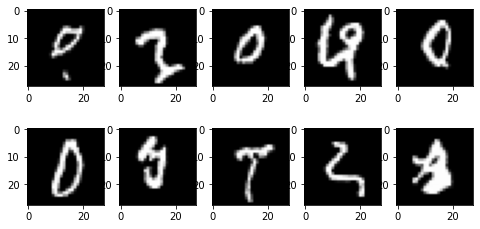

In [18]:
fig = plt.figure(figsize=(8, 4))
columns = 5
rows = 2
for i, img in enumerate(sampled_images):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img.squeeze().cpu().numpy(), cmap="gray")
plt.show()

The quality is not ideal, but you start to see the outlines of actual numbers. We could train for a longer time to improve the image quality, but LSTMs are inherently slow to train. Instead we will focus on PixelCNNs in the next two notebooks, as those can be much better parallelized.